In [1]:
#tf.__version__
import tensorflow as tf

tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:39:05) [MSC v.1929 64 bit (AMD64)]
Pandas 2.2.3
Scikit-Learn 1.6.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


### InceptionV3

To zaawansowana siec konwolucyjna zaprojektowana przez zespół Google w ramch modeli Inception.

Jest powszechnie używany w zadaniach z klasyfikacji obrazów i uczeniem transferowym.
Składa sie z ponad 40 warstw (konwolucyjnych, poolingowych, i w pełni połączonych)

W tradycyjnej sieci konwolucyjnej używamy tylko jednej wilekosci filtra. W Inception każdy blok równolegle przetwarza dane zróznymi filtrami:
- 1x1 do redukcji wymiarowosci danych  i uproszczenia obliczen
- 3x3 i 5x5 do znalezienia lokalnych cech obrazu na róznych skalach

##### Zastosowanie Transfer-Learning

Uzywajac pretrenowanego modelu InceptionV3
- Zaszcz

In [2]:
import pickle
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import  InceptionV3

from livelossplot import PlotLossesKeras

np.random.seed(42)


### Wczytywanie danych 

In [3]:

train_dir = r"..\input\train"
test_dir = r"..\input\test"

### Tworzenie generatora danych 
Generator bedzie skalował wartosci pikseli obrazów do zakresu [0,1] i ustalał podział danych na dane walidacyjne i treningowe

In [4]:
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(299,299),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(299,299),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")


Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Number of classes: 7


trian_generation i validation_generator , które będa słuzyc do ładowania obrazów w partiach z zachowaniem rozdzielczosci 75x75 pikseli
Ładowane sa w partiach po 32 obrazy

Rozmiar ten jest dostosowywany do obrazu wymaganego przez model. 

Model InceptionV3 zaprojektowano do przetwarzania obrazów w formacie RGB(3 kanały) i wymiarach 299x299. W implelentacji Keras umożliwia zmiane rozmiaru obrazu wejsciowego.

Wybieram rozmiar 75x75 poniewaz pozwala szybciej tenowac model

### Wykrywanie liczby klas

In [5]:
print(f"Train class indices: {train_generator.class_indices}")
print(f"Validation class indices: {validation_generator.class_indices}")

Train class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Validation class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


### Ładowanie modelu i konfiguracja modelu bazowego
Załaduje Model bazowy InceptionV3 bez ostatniej warstwy klasyfikacyjnej (include_top= False) i dostosowany do obrazu wejsciowego

In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

### Proces odmrazania warstw konwolucyjnych

- Najpierw zamrazamy wszystie warstwy modelu 
- Nastepnie okreslamy ilosc warstw które maja byc trenowane
- Potem odmrazamy warstwy które maja byc trenowane

Aby zachowac wagi wczesniejszych warstw modelu (ich wstepenie wytrenowana wiedze) pozostałem warstwy powinny byc zamrożone

In [31]:
#Zamrozenie wszystkich warstw
for layer in base_model.layers:
    layer.trainable = False

i = 40

# Odmrazanie ostatnich i warstw
for layer in base_model.layers[-i:]:
    layer.trainable = True

#Sprawdzenie statusu warstw
for i, layer in enumerate(base_model.layers):
    print(f' Layer {i} : {layer.name}, Trainable: {layer.trainable}')

 Layer 0 : input_1, Trainable: False
 Layer 1 : conv2d, Trainable: False
 Layer 2 : batch_normalization, Trainable: False
 Layer 3 : activation, Trainable: False
 Layer 4 : conv2d_1, Trainable: False
 Layer 5 : batch_normalization_1, Trainable: False
 Layer 6 : activation_1, Trainable: False
 Layer 7 : conv2d_2, Trainable: False
 Layer 8 : batch_normalization_2, Trainable: False
 Layer 9 : activation_2, Trainable: False
 Layer 10 : max_pooling2d, Trainable: False
 Layer 11 : conv2d_3, Trainable: False
 Layer 12 : batch_normalization_3, Trainable: False
 Layer 13 : activation_3, Trainable: False
 Layer 14 : conv2d_4, Trainable: False
 Layer 15 : batch_normalization_4, Trainable: False
 Layer 16 : activation_4, Trainable: False
 Layer 17 : max_pooling2d_1, Trainable: False
 Layer 18 : conv2d_8, Trainable: False
 Layer 19 : batch_normalization_8, Trainable: False
 Layer 20 : activation_8, Trainable: False
 Layer 21 : conv2d_6, Trainable: False
 Layer 22 : conv2d_9, Trainable: False
 Layer

### Budowa Modelu 
Buduje model Sequential do którego dołacze model bazowy


In [32]:

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Model kompiluje z  optymalizatorem Adam, ustawiajac tempo ucznie 0,001 z parametrem  decay= 0.0005 oraz funkcja strat

### Konfiguracja szkolenia

In [33]:
callbacks = [
    PlotLossesKeras(),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    
    ModelCheckpoint(filepath= r'..\models\emotion_model_InceptionV3_model_{epoch:02d}_{val_loss:.2f}.keras', 
                    monitor='val_loss', save_best_only=True, mode='min' , verbose=1),
    ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_lr=1e-6 ) 
]


- PlotLossesKeras zwraca z kazda epoką wykres strat i dokładnoscina dla zbioru treningowego i walidacyjnego w czasie trenowania
- EarlyStopping zatrzymuje trenowanie, gdy val_loss nie poprawia sie poprzez 5 epok
- ModelCheckpoint zapisuje najlepsza wersje modelu na podstawie epoki i val_loss
- ReduceLROPlateau zmniejsza tempo uczenia o wspołczynnik 0,1 gdy val_loss przestaje sie poprawiac przez 10 epok 

### Trenowanie modelu na GPU
Model bedzie trenowany przez 50 epok na GPU

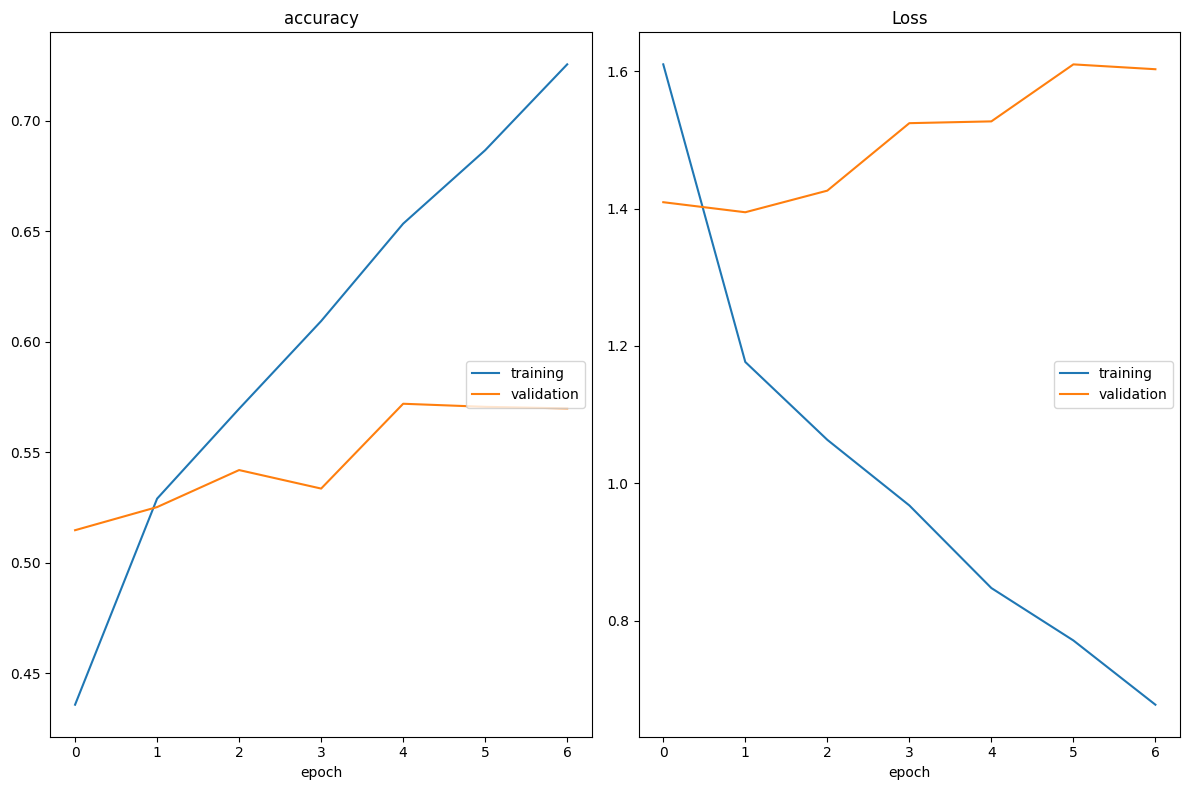

accuracy
	training         	 (min:    0.436, max:    0.726, cur:    0.726)
	validation       	 (min:    0.515, max:    0.572, cur:    0.570)
Loss
	training         	 (min:    0.678, max:    1.610, cur:    0.678)
	validation       	 (min:    1.395, max:    1.610, cur:    1.603)

Epoch 7: val_loss did not improve from 1.39454
718/718 [==============================] - 46s 64ms/step - loss: 0.6776 - accuracy: 0.7256 - val_loss: 1.6028 - val_accuracy: 0.5698 - lr: 0.0010
Epoch 7: early stopping


In [34]:

with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=50,
        callbacks=callbacks,
        validation_data=validation_generator
    )


In [ ]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(299,299),
    batch_size=32,
    class_mode='categorical'
)

loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

### Podsumowanie

Transfer Learning z wykorzystaniem modelu InceptionV3 